In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SOURCE = "dukascopy"
SYMBOL = "usdjpy"
MINUTES = 1
START_DATE = "2021-01-01"
END_DATE = "2024-12-31"

# Build base name
BASE_NAME = f"{SOURCE}-{SYMBOL}-tick-{START_DATE}-{END_DATE}"
RESAMPLED_NAME = f"{SOURCE}-{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"
# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"

In [3]:
EVENT_NAME = 'cusum_filter'
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(RESAMPLED_FILE_PATH)

CPU times: user 549 μs, sys: 11.8 ms, total: 12.4 ms
Wall time: 15.4 ms


In [5]:
df.shape

(1480352, 7)

In [6]:
df.head()

,timestamp,open,high,low,close,volume,spread
373333,2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600
373334,2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600
373335,2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000
373336,2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500
373337,2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857


In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

df = df.set_index('timestamp')

df.head()

,open,high,low,close,volume,spread
timestamp,,,,,,
2021-01-03 22:00:00,103.1185,103.1720,103.1175,103.1720,16990.000002,0.025600
2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600
2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000
2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500
2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857


In [8]:
import numpy as np

df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['log_volume'] = np.log1p(df['volume'])
df = df.dropna()

In [9]:
df.head()

,open,high,low,close,volume,spread,log_return,log_volume
timestamp,,,,,,,,
2021-01-03 22:01:00,103.1725,103.1740,103.1725,103.1740,4979.999989,0.025600,0.000019,8.513386
2021-01-03 22:02:00,103.2150,103.2330,103.2150,103.2330,2369.999997,0.090000,0.000572,7.771067
2021-01-03 22:03:00,103.2050,103.2075,103.1955,103.1955,6750.000000,0.041500,-0.000363,8.817446
2021-01-03 22:04:00,103.1965,103.2080,103.1965,103.2070,9740.000010,0.022857,0.000111,9.184099
2021-01-03 22:05:00,103.2075,103.2110,103.2075,103.2105,10470.000029,0.021875,0.000034,9.256365


## Get Events Start Time (t0)

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_tevents_optimized(data: pd.Series, threshold: float) -> pd.DatetimeIndex:
    values = data.values
    timestamps = data.index

    s_pos = np.zeros_like(values)
    s_neg = np.zeros_like(values)

    t_events_mask = np.zeros_like(values, dtype=bool)

    cum_pos, cum_neg = 0.0, 0.0

    for i in tqdm(range(len(values))):
        cum_pos = max(0.0, cum_pos + values[i])
        cum_neg = min(0.0, cum_neg + values[i])
        s_pos[i] = cum_pos
        s_neg[i] = cum_neg

        if cum_pos > threshold:
            t_events_mask[i] = True
            cum_pos = 0.0
        if cum_neg < -threshold:
            t_events_mask[i] = True
            cum_neg = 0.0

    return timestamps[t_events_mask]


In [11]:
%%time

t_events = get_tevents_optimized(df['log_return'].iloc[1:], 1e-3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1480350/1480350 [00:00<00:00, 3914933.74it/s]

CPU times: user 374 ms, sys: 11.5 ms, total: 386 ms
Wall time: 390 ms


In [12]:
t_events

DatetimeIndex(['2021-01-03 23:20:00', '2021-01-04 00:01:00',
               '2021-01-04 00:29:00', '2021-01-04 01:35:00',
               '2021-01-04 02:24:00', '2021-01-04 05:16:00',
               '2021-01-04 07:12:00', '2021-01-04 07:46:00',
               '2021-01-04 08:30:00', '2021-01-04 11:09:00',
               ...
               '2024-12-30 16:06:00', '2024-12-30 16:22:00',
               '2024-12-30 17:01:00', '2024-12-30 17:54:00',
               '2024-12-30 18:35:00', '2024-12-30 19:58:00',
               '2024-12-30 20:30:00', '2024-12-30 21:06:00',
               '2024-12-30 22:33:00', '2024-12-30 23:16:00'],
              dtype='datetime64[ns]', name='timestamp', length=36985, freq=None)

In [13]:
df.loc[t_events]

,open,high,low,close,volume,spread,log_return,log_volume
timestamp,,,,,,,,
2021-01-03 23:20:00,103.2740,103.2945,103.2735,103.2945,175020.002007,0.005963,0.000174,12.072661
2021-01-04 00:01:00,103.2290,103.2325,103.1950,103.2065,383980.002165,0.003228,-0.000203,12.858348
2021-01-04 00:29:00,103.1230,103.1250,103.1085,103.1130,200270.002246,0.002810,-0.000102,12.207427
2021-01-04 01:35:00,103.1125,103.1215,103.1105,103.1190,118640.000939,0.003147,0.000048,11.683857
2021-01-04 02:24:00,103.0310,103.0335,103.0135,103.0150,160380.001426,0.003083,-0.000150,11.985308
...,...,...,...,...,...,...,...,...
2024-12-30 19:58:00,157.0775,157.0975,157.0715,157.0965,630179.994345,0.006341,0.000143,13.353762
2024-12-30 20:30:00,156.9610,156.9620,156.9500,156.9500,290249.996901,0.006233,-0.000076,12.578501
2024-12-30 21:06:00,156.8175,156.8175,156.7810,156.7860,490710.001230,0.007143,-0.000195,13.103611


In [14]:
# 確保 df.index 和 t_events 都是 datetime 類型
df.index = pd.to_datetime(df.index)
t_events = pd.to_datetime(t_events)

# 過濾出 2020 年的 df
df_2020 = df.loc["2021-01"]

# 過濾出 t_events 中屬於 2020 年的事件
t_events_2020 = t_events[(t_events >= "2021-01-01") & (t_events < "2021-02-01")]


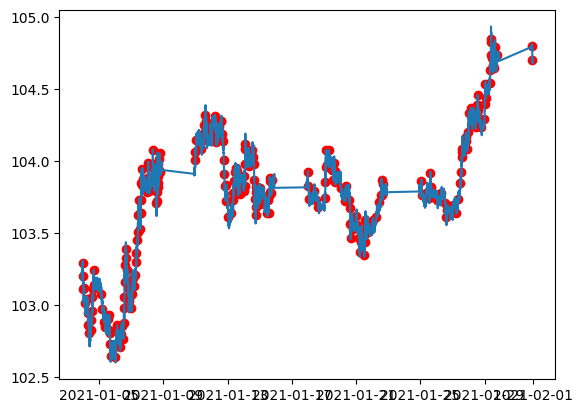

In [15]:
from matplotlib import pyplot as plt
close = df_2020['close']
plt.plot(close)
plt.scatter(t_events_2020, close.loc[t_events_2020], c='red')

## Calculate Target Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [16]:
def get_daily_vol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [17]:
%%time
daily_vol = get_daily_vol(df['close'])

CPU times: user 201 ms, sys: 12.1 ms, total: 213 ms
Wall time: 213 ms


In [18]:
trgt = daily_vol.reindex(t_events, method='ffill')
trgt.describe()

count    36969.000000
mean         0.001444
std          0.001379
min          0.000086
25%          0.000656
50%          0.001047
75%          0.001710
max          0.013479
Name: dailyVol, dtype: float64

In [19]:
from ta.volatility import AverageTrueRange

def get_atr(closes, window=60):
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=window)
    return atr.average_true_range().rename(f"atr{window}")

In [20]:
%%time
atr60 = get_atr(df['close'], window=60)

CPU times: user 1.73 s, sys: 16.1 ms, total: 1.74 s
Wall time: 1.74 s


In [21]:
trgt = atr60.reindex(t_events, method='ffill')
trgt.describe()

count    36985.000000
mean         0.039246
std          0.029019
min          0.002808
25%          0.021596
50%          0.032342
75%          0.047228
max          0.286193
Name: atr60, dtype: float64

In [22]:
def get_intraday_vol(log_return, window=60, span=60):
    rolling_std = log_return.rolling(window=window).std()
    smoothed_vol = rolling_std.ewm(span=span).mean()
    return smoothed_vol.rename(f'intraday_vol_{window}_{span}')

In [23]:
intraday_vol = get_intraday_vol(df['log_return'], window=60, span=60)

In [24]:
trgt = 5 * intraday_vol.reindex(t_events, method='ffill')
trgt.describe()

count    36985.000000
mean         0.001066
std          0.000858
min          0.000097
25%          0.000582
50%          0.000844
75%          0.001227
max          0.010377
Name: intraday_vol_60_60, dtype: float64

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [25]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events_['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events_['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None:
        events = events.drop('side', axis=1)
    return events


In [26]:
def get_vertical_barrier(t_events, close, delta=pd.Timedelta(minutes=60)):
    """
    For each event in t_events, find the timestamp in close.index 
    that is at least delta later. Returns a pd.Series of t1.
    """
    barrier_times = t_events + delta
    t1_idx = close.index.searchsorted(barrier_times)
    valid_idx = t1_idx[t1_idx < len(close)]
    t1 = pd.Series(close.index[valid_idx], index=t_events[:len(valid_idx)])
    return t1

In [27]:
t1 = get_vertical_barrier(t_events, df['close'], delta=pd.Timedelta(minutes=60))

In [28]:
t1

timestamp
2021-01-03 23:20:00   2021-01-04 00:20:00
2021-01-04 00:01:00   2021-01-04 01:01:00
2021-01-04 00:29:00   2021-01-04 01:29:00
2021-01-04 01:35:00   2021-01-04 02:35:00
2021-01-04 02:24:00   2021-01-04 03:24:00
                              ...        
2024-12-30 18:35:00   2024-12-30 19:35:00
2024-12-30 19:58:00   2024-12-30 20:58:00
2024-12-30 20:30:00   2024-12-30 21:30:00
2024-12-30 21:06:00   2024-12-30 22:06:00
2024-12-30 22:33:00   2024-12-30 23:33:00
Name: timestamp, Length: 36984, dtype: datetime64[ns]

## Calculate minRet

In [29]:
min_ret = 0.5 * atr60.median()
min_ret

np.float64(0.00913947852803245)

In [30]:
%%time

events = getEvents(df['close'], t_events, [1,1], trgt, 0, 8, t1=t1, side=None)

CPU times: user 9.79 s, sys: 774 ms, total: 10.6 s
Wall time: 9.86 s


In [31]:
events

,t1,trgt
timestamp,,
2021-01-03 23:20:00,2021-01-03 23:32:00,0.000435
2021-01-04 00:01:00,2021-01-04 00:10:00,0.000459
2021-01-04 00:29:00,2021-01-04 00:40:00,0.000519
2021-01-04 01:35:00,2021-01-04 01:50:00,0.000566
2021-01-04 02:24:00,2021-01-04 03:24:00,0.000488
...,...,...
2024-12-30 19:58:00,2024-12-30 20:03:00,0.000393
2024-12-30 20:30:00,2024-12-30 20:34:00,0.000370
2024-12-30 21:06:00,2024-12-30 21:46:00,0.000409


In [32]:
events['duration'] = events['t1'] - events.index
events['duration'].describe()

count                        36985
mean     0 days 00:32:58.366364742
std      0 days 01:46:53.547397921
min                0 days 00:01:00
25%                0 days 00:11:00
50%                0 days 00:24:00
75%                0 days 00:50:00
max                2 days 02:00:00
Name: duration, dtype: object

In [33]:
longest_idx = events['duration'].idxmax()
longest_event = events.loc[longest_idx]
print(f"Longest event index: {longest_idx}")
print(longest_event)


Longest event index: 2024-09-27 20:00:00
t1          2024-09-29 22:00:00
trgt                   0.000789
duration        2 days 02:00:00
Name: 2024-09-27 20:00:00, dtype: object


#

In [34]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [35]:
labels = getBins(events, df['close'], t1=t1)
labels["bin_class"] = labels["bin"] + 1
labels

,ret,bin,bin_class
timestamp,,,
2021-01-03 23:20:00,-0.000474,-1.0,0.0
2021-01-04 00:01:00,-0.000523,-1.0,0.0
2021-01-04 00:29:00,-0.000771,-1.0,0.0
2021-01-04 01:35:00,-0.000664,-1.0,0.0
2021-01-04 02:24:00,-0.000194,0.0,1.0
...,...,...,...
2024-12-30 19:58:00,-0.000395,-1.0,0.0
2024-12-30 20:30:00,-0.000392,-1.0,0.0
2024-12-30 21:06:00,0.000507,1.0,2.0


In [36]:
labels.bin.value_counts()

bin
 1.0    14268
-1.0    13719
 0.0     8998
Name: count, dtype: int64

In [37]:
labeled_events = events.join(labels, how='inner')

## Calculate Concurrency

In [38]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [39]:
# Let's say your OHLCV data or close series has this index
price_index = close.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

(array([2.0867e+04, 0.0000e+00, 7.6680e+03, 0.0000e+00, 0.0000e+00,
        1.4800e+02, 0.0000e+00, 4.8000e+01, 0.0000e+00, 1.0000e+00]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

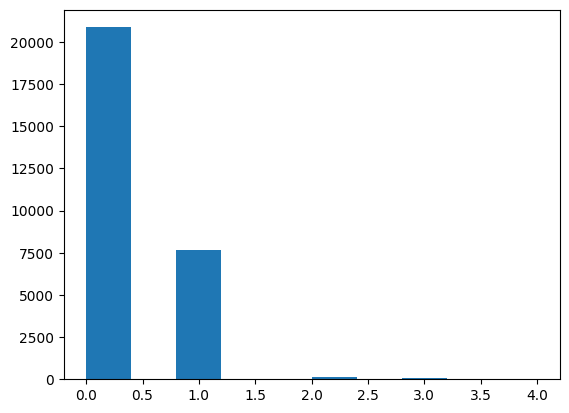

In [40]:
plt.hist(concurrency)

## Save events to disk

In [41]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)